In [40]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import numpy as np
import random
import nltk
nltk.download('punkt')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import sentiwordnet as swn
import string
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [42]:
def load_dataset():
  column_names = [ 'id', 'text', 'is_humor', 'humor_rating', 'humor_controversy', 'offense_rating' ]
  data_path = '/content/drive/My Drive/data-nlp-humor-offense/train.csv'
  data_frame = pd.read_csv(data_path, names=column_names, skiprows=1, na_values="?", sep=",", skipinitialspace=True)
  data = data_frame.fillna(0).to_numpy()

  return data, data_frame

In [43]:
result, df_result = load_dataset()
print(result[:5])

[[1
  "TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit..."
  1 2.42 1.0 0.2]
 [2
  'A man inserted an advertisement in the classifieds "Wife Wanted". The next day, he received 1000 of replies, all reading: "You can have mine." Free delivery also available at your door step'
  1 2.5 1.0 1.1]
 [3
  'How many men does it take to open a can of beer? None. It should be open by the time she brings it to the couch.'
  1 1.95 0.0 2.4]
 [4
  "Told my mom I hit 1200 Twitter followers. She pointed out how my brother owns a house and I'm wanted by several collection agencies. Oh ma!"
  1 2.11 1.0 0.0]
 [5
  'Roses are dead. Love is fake. Weddings are basically funerals with cake.'
  1 2.78 0.0 0.1]]


In [44]:
def format_text_to_one_hot(array_of_texts):
  vocabulary = []
  vocabulary_map = {}
  counter = 1
  end_result = []
  texts_scores = []

  for text in array_of_texts:
    
    text_represented_with_numbers = []
    positive_text_score = 0
    negative_text_score = 0
    # break the text into sentences
    sentences = sent_tokenize(text)

    for sentence in sentences:

      # break the sentence into words
      words_array = word_tokenize(sentence)

      for word in words_array:

        # remove punctuation
        word = word.translate(str.maketrans('', '', string.punctuation))
        
        # lower case all letters 
        word = word.lower()

        if word != '' and word != 's':
          if not vocabulary.__contains__(word):
            vocabulary.append(word)
            vocabulary_map[word] = counter
            counter += 1
          
          text_represented_with_numbers.append(vocabulary_map[word])

        # add positive negative score

    # add text to result array
    end_result.append(text_represented_with_numbers)
   # difference = positive_text_score/negative_text_score
   # texts_scores.append(difference)
  
  # arrays to have same length
  padded_seq = pad_sequences(end_result, maxlen=63, dtype='int32', padding='pre', value=0.0)
  print(len(vocabulary))
  return padded_seq

In [45]:
texts = df_result['text']
values = df_result['is_humor']
np.save('/tmp/values', values)
print(len(texts))
with tf.device('/GPU:0'):
  formatted_texts = format_text_to_one_hot(texts)
np.save('/tmp/formatted_texts', formatted_texts)
print(len(formatted_texts))

8000
15050
8000


In [46]:
# n - NOUN
#v - VERB
#a - ADJECTIVE
#s - ADJECTIVE SATELLITE
#r - ADVERB

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    

def getPostTags(array_of_texts):
  vocabulary = []
  vocabulary_map = {}
  counter = 1
  end_result = []
  texts_scores = []
  postagging = []

  for text in array_of_texts:
    
    text_represented_with_numbers = []
    positive_text_score = 0
    negative_text_score = 0
    # break the text into sentences
    sentences = sent_tokenize(text)
    posttagging_sentences = []
    for sentence in sentences:

      # break the sentence into words
      words_array = word_tokenize(sentence)
      stop_words = set(stopwords.words('english'))
      filtered_sentence = [w for w in words_array if not w in stop_words] 

      # remove punctuation
      word_tokens2 = [w for w in filtered_sentence if not w in string.punctuation]
      # lower case all letters 
      lower_case_sentance = map(lambda w: w.lower(), word_tokens2)
      #lemmatization
      lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]
        
      # Remove characters which have length less than 2  
      without_single_chr = [word for word in lemmatized_output if len(word) > 2]
      # Remove numbers
      cleaned_data = [word for word in without_single_chr if not word.isnumeric()]
      
      posttagging_sentences.append(nltk.pos_tag(cleaned_data))
    
    postagging.append(posttagging_sentences)
  return postagging

In [47]:
senti_score = []
pos=neg=obj=count=0
posttagging = getPostTags(df_result['text'])
print(posttagging[:5])
count1 = 1
for text in posttagging:
  senti_scores_text = 0
  for sentence in text:
    
    senti_val = [get_sentiment(x,y) for (x,y) in sentence]
    for score in senti_val:
      try:
        pos = pos + score[1]  #positive score is stored at 2nd position
        neg = neg + score[2]  #negative score is stored at 3rd position
      except:
        continue
    result_score = pos - neg
    senti_scores_text += result_score 
    pos=neg=0 
  senti_score.append(senti_scores_text)

[[[('TENNESSEE', 'NNP'), ("'re", 'VBP'), ('best', 'JJS'), ('state', 'NN')], [('Nobody', 'NN'), ('even', 'RB'), ('come', 'VBP'), ('close', 'RB')], [('*Elevennessee', 'NN'), ('walk', 'NN'), ('room*', 'NN'), ('TENNESSEE', 'NNP'), ('shit', 'NN'), ('...', ':')]], [[('man', 'NN'), ('inserted', 'VBD'), ('advertisement', 'JJ'), ('classified', 'JJ'), ('Wife', 'NNP'), ('Wanted', 'VBD')], [('The', 'DT'), ('next', 'JJ'), ('day', 'NN'), ('received', 'VBD'), ('reply', 'RB'), ('reading', 'VBG'), ('You', 'PRP'), ('mine', 'VBP')], [('Free', 'JJ'), ('delivery', 'NN'), ('also', 'RB'), ('available', 'JJ'), ('door', 'JJ'), ('step', 'NN')]], [[('How', 'WRB'), ('many', 'JJ'), ('men', 'NNS'), ('take', 'VBP'), ('open', 'JJ'), ('beer', 'NN')], [('None', 'NN')], [('open', 'JJ'), ('time', 'NN'), ('brings', 'VBZ'), ('couch', 'JJ')]], [[('Told', 'NNP'), ('mom', 'NN'), ('hit', 'VBD'), ('Twitter', 'NNP'), ('follower', 'NN')], [('She', 'PRP'), ('pointed', 'VBD'), ('brother', 'RB'), ('owns', 'VBZ'), ('house', 'NN'), ('

In [48]:
from sklearn import preprocessing

senti_score_normalized = preprocessing.normalize([senti_score])
print(senti_score_normalized[:2])

scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(np.asarray(senti_score).reshape(-1, 1))
senti_score = d.reshape(1, -1)[0]

[[ 0.0111316   0.01335793 -0.01335793 ...  0.00222632  0.
   0.00445264]]


In [49]:
text_data, senti_data, labels = [], [], []

for i in range(0, len(df_result['is_humor'])):
    text_data.append(formatted_texts[i])
    senti_data.append(senti_score[i])
    labels.append(df_result['offense_rating'][i])


total = len(text_data)
train_per = int(0.75 * total)

train_data, train_labels = [], []
test_data, test_labels = [], []

for i in range(0, total):
  if (i < train_per):
    list = np.append(text_data[i], senti_data[i])
    train_data.append(list)
    #train_data.append(text_data[i])
    train_labels.append(labels[i])
  else:
    list = np.append(text_data[i], senti_data[i])
    test_data.append(list)
    #test_data.append(text_data[i])
    test_labels.append(labels[i])

train_data = np.asarray(train_data)
train_labels = np.asarray(train_labels)
test_data = np.asarray(test_data)
test_labels = np.asarray(test_labels)

In [50]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(15500, 32, input_length=len(train_data[0]), mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,kernel_regularizer=tf.keras.regularizers.l2(0.0001))),
    tf.keras.layers.Dense(1, kernel_initializer='normal')
])

In [51]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
#predictions = model.predict(np.array([sample_text]))
#print(predictions[0])

In [52]:
model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(0.00005),
              metrics=['mse'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto')

In [53]:
print(train_data[0])
print(train_data[1])

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        1.        2.        3.        4.
  5.        6.        7.        8.        9.       10.       11.
 12.       13.        4.       14.        1.       15.       16.
  0.546875]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     17.     18.     19.     20.     21.
 22.      4.     23.     24.     25.      4.     26.     27.     28.
 29.     30.     31.     32.     33.     34.     35.     3

In [54]:

with tf.device('/GPU:0'):
  history = model.fit(train_data, train_labels, epochs=500, validation_split=0.25, verbose=1, callbacks=callback)

Epoch 1/500
141/141 [==============================] - 24s 120ms/step - loss: 1.2537 - mse: 1.2429 - val_loss: 1.1603 - val_mse: 1.1500
Epoch 2/500
141/141 [==============================] - 15s 103ms/step - loss: 1.0430 - mse: 1.0331 - val_loss: 0.9955 - val_mse: 0.9859
Epoch 3/500
141/141 [==============================] - 15s 105ms/step - loss: 0.9668 - mse: 0.9575 - val_loss: 0.9495 - val_mse: 0.9404
Epoch 4/500
141/141 [==============================] - 15s 105ms/step - loss: 0.9080 - mse: 0.8991 - val_loss: 0.9031 - val_mse: 0.8943
Epoch 5/500
141/141 [==============================] - 15s 105ms/step - loss: 0.8430 - mse: 0.8342 - val_loss: 0.8549 - val_mse: 0.8463
Epoch 6/500
141/141 [==============================] - 14s 103ms/step - loss: 0.7487 - mse: 0.7400 - val_loss: 0.7925 - val_mse: 0.7838
Epoch 7/500
141/141 [==============================] - 14s 102ms/step - loss: 0.6294 - mse: 0.6207 - val_loss: 0.7438 - val_mse: 0.7351
Epoch 8/500
141/141 [===========================

In [55]:
with tf.device('/GPU:0'):
  test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=1)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

63/63 [==============================] - 1s 20ms/step - loss: 0.6913 - mse: 0.6830
Test Loss: 0.6912557482719421
Test Accuracy: 0.6829736232757568


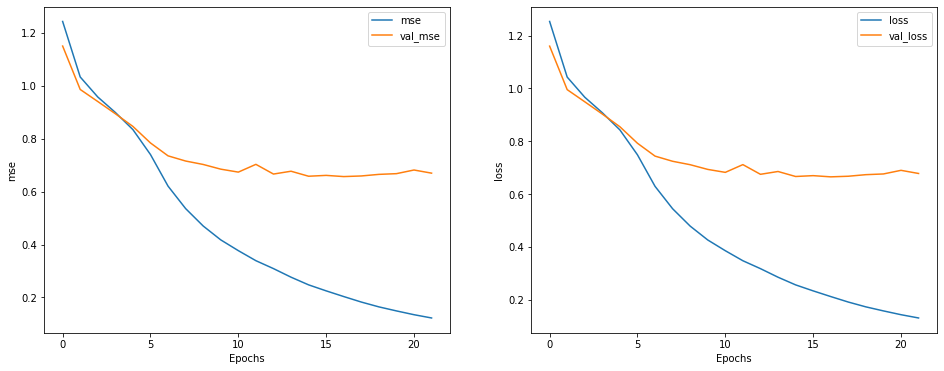

In [56]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'mse')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [57]:
test_predictions = model.predict(test_data)
print(test_predictions[:10])

[[ 0.372195  ]
 [-0.02992792]
 [ 0.309001  ]
 [ 0.6969156 ]
 [ 1.6444775 ]
 [ 0.2015199 ]
 [ 0.9532943 ]
 [ 0.11262735]
 [ 0.26284274]
 [-0.10522017]]


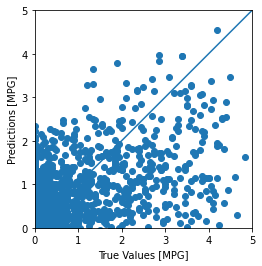

In [58]:
import matplotlib.pyplot as plt

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)